In [1]:
import nd2

In [2]:
nd2_path ="/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250711/tmem67_start31hpf_20250711.nd2"

In [3]:
with nd2.ND2File(nd2_path) as f:
    print("shape:", f.shape)         # typically (T, W, Z, C, Y, X)
    print("sizes:", getattr(f, "sizes", None))
    ch = [c.channel.name for c in f.frame_metadata(0).channels]
    print("channels:", ch)
    try:
        print("voxel_size:", f.voxel_size())
    except Exception as e:
        print("voxel_size error:", e)
  

shape: (179, 93, 15, 2189, 1152)
sizes: {'T': 179, 'P': 93, 'Z': 15, 'Y': 2189, 'X': 1152}
channels: ['EYES - Dia']
voxel_size: VoxelSize(x=3.230785403120142, y=3.230785403120142, z=50.0)


In [6]:
import nd2
import matplotlib.pyplot as plt
from tifffile import imsave

with nd2.ND2File(nd2_path) as f:
    print("Sizes:", f.sizes)         # e.g. {'T': 179, 'P': 93, 'Z': 15, 'Y': 2189, 'X': 1152}
    print("Dtype:", f.dtype)
    data = f.asarray()               # numpy array with full content
    print("Array shape:", data.shape)
    
    # Quick view of the very first frame:
    first_frame = data[0, 0, 0, ...]  # adjust indexing if dims are T, P, Z, Y, X
    plt.imshow(first_frame, cmap='gray')
    plt.axis('off')
    plt.show()

    # Or save it to disk quickly:
    imsave("test_frame.tif", first_frame.astype(f.dtype))

Sizes: {'T': 179, 'P': 93, 'Z': 15, 'Y': 2189, 'X': 1152}
Dtype: uint16


MemoryError: Unable to allocate 1.15 TiB for an array with shape (249705, 2189, 1152) and data type uint16

In [ ]:
with nd2.ND2File(nd2_path) as f:
    arr = f.to_dask()   # lazy, doesn't load everything yet
    slice2d = arr[0, 0, :, :, :].max(axis=0)  # (Y, X)
    img = slice2d.compute()  # pulls ONLY this slice into memory
    import imageio
    imageio.imwrite("/net/trapnell/vol1/home/mdcolon/proj/morphseq/shot.png", img)



In [15]:
with nd2.ND2File("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250512/cep290_starthpf_12_20250.nd2") as f:
    arr = f.to_dask()   # lazy, doesn't load everything yet
    slice2d = arr[0, 0, :, :, :].max(axis=0)  # (Y, X)
    img = slice2d.compute()  # pulls ONLY this slice into memory
    import imageio
    imageio.imwrite("/net/trapnell/vol1/home/mdcolon/proj/morphseq/shot_cep.png", img)



In [16]:
with nd2.ND2File("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250512/cep290_starthpf_12_20250.nd2") as f:
    print("shape:", f.shape)         # typically (T, W, Z, C, Y, X)
    print("sizes:", getattr(f, "sizes", None))
    ch = [c.channel.name for c in f.frame_metadata(0).channels]
    print("channels:", ch)
    try:
        print("voxel_size:", f.voxel_size())
    except Exception as e:
        print("voxel_size error:", e)
  

shape: (195, 96, 15, 2189, 1152)
sizes: {'T': 195, 'P': 96, 'Z': 15, 'Y': 2189, 'X': 1152}
channels: ['BF']
voxel_size: VoxelSize(x=3.230785403120142, y=3.230785403120142, z=50.0)


In [17]:

import nd2, pandas as pd, numpy as np
import pathlib

exp = "20250520"  # change to your experiment
nd2_path = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/{exp}"
xlsx     = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/well_metadata/{exp}_well_metadata.xlsx"

# find an ND2 in the folder
nd2_files = list(pathlib.Path(nd2_path).glob("*.nd2"))
if not nd2_files:
    print("❌ No ND2 found in", nd2_path)
    raise SystemExit(1)
nd2_file = str(nd2_files[0])

with nd2.ND2File(nd2_file) as f:
    sizes = f.sizes
P = sizes.get("P", sizes.get("W", None))
T = sizes.get("T", None)
print(f"ND2 sizes: {sizes} -> Positions P={P}, Time T={T}")

# series_number_map is 8x12 grid under sheet name 'series_number_map'
sm = pd.read_excel(xlsx, sheet_name="series_number_map", header=None)
series = sm.iloc[:8, 1:13].to_numpy().ravel()
series = np.array([int(x) for x in series if pd.notna(x)], dtype=int)   # 1-based

print(f"Selected wells in Excel: n={len(series)}")
if series.size:
    print(f"Min series={series.min()} Max series={series.max()} (valid range: 1..{P})")
    dups = [int(x) for x, c in zip(*np.unique(series, return_counts=True)) if c > 1]
    oor  = [int(x) for x in series if x < 1 or (P is not None and x > P)]
    print(f"Duplicates: {dups or 'none'}")
    print(f"Out-of-range: {oor or 'none'}")

    # show first/last 5 mappings (well -> ND2 series), to spot odd values
    row_letters = list("ABCDEFGH")
    plate = []
    for r in range(8):
        for c in range(1, 13):
            val = sm.iat[r, c]
            if pd.notna(val):
                plate.append((f"{row_letters[r]}{c:02d}", int(val)))
    plate.sort(key=lambda x: x[1])
    print("First 5 mapped wells:", plate[:5])
    print("Last 5 mapped wells:", plate[-5:])


ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152} -> Positions P=94, Time T=190
Selected wells in Excel: n=66
Min series=1 Max series=64 (valid range: 1..94)
Duplicates: [1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
Out-of-range: none
First 5 mapped wells: [('A01', 1), ('B01', 1), ('A02', 2), ('C01', 2), ('A03', 3)]
Last 5 mapped wells: [('F08', 60), ('E08', 61), ('D08', 62), ('C08', 63), ('B08', 64)]


In [23]:
# Cell 1 — Locate ND2
from pathlib import Path
import nd2, pandas as pd

exp = "20250520"  # change to your experiment
nd2_dir = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/{exp}"
xlsx     = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/well_metadata/{exp}_well_metadata.xlsx"


nd2_files = list(Path(nd2_dir).glob("*.nd2"))
if not nd2_files:
    raise FileNotFoundError(f"No ND2 found in {nd2_dir}")
nd2_path = nd2_files[0]
print("ND2 file:", nd2_path)




ND2 file: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250520/b9d2_starthpf_31_20250520.nd2


In [ ]:
from pathlib import Path
import nd2

exp = "20250520"
base = 
Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes["Z"]

    def has_seq(w, t):
        seq = (t * P + w) * Z
        try:
            f.frame_metadata(seq)
            print(f"s")
            return True
        except Exception:
            return False

    for w in range(0, 96):  # change the range or use your selected wells
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break
        print(f"well ND2 index {w}: frames available = {t_avail}/{T}")

well ND2 index 0: frames available = 40/190
well ND2 index 1: frames available = 40/190
well ND2 index 2: frames available = 40/190
well ND2 index 3: frames available = 40/190
well ND2 index 4: frames available = 40/190
well ND2 index 5: frames available = 40/190
well ND2 index 6: frames available = 40/190
well ND2 index 7: frames available = 40/190
well ND2 index 8: frames available = 40/190
well ND2 index 9: frames available = 40/190
well ND2 index 10: frames available = 40/190
well ND2 index 11: frames available = 40/190
well ND2 index 12: frames available = 40/190
well ND2 index 13: frames available = 40/190
well ND2 index 14: frames available = 40/190
well ND2 index 15: frames available = 40/190
well ND2 index 16: frames available = 40/190
well ND2 index 17: frames available = 40/190
well ND2 index 18: frames available = 40/190
well ND2 index 19: frames available = 40/190
well ND2 index 20: frames available = 40/190
well ND2 index 21: frames available = 40/190
well ND2 index 22: f

In [31]:
from pathlib import Path
import nd2

# EDIT THESE
exp = "20250520"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

print("ND2 file:", nd2_path)
with nd2.ND2File(str(nd2_path)) as f:
    print("sizes:", f.sizes)  # e.g. {'T':190,'P':94,'Z':15,'Y':2189,'X':1152}
    print("channels:", [c.channel.name for c in f.frame_metadata(0).channels])
    try:
        print("voxel_size:", f.voxel_size())
    except Exception as e:
        print("voxel_size err:", e)

ND2 file: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250520/b9d2_starthpf_31_20250520.nd2
sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
channels: ['BF']
voxel_size: VoxelSize(x=3.230785403120142, y=3.230785403120142, z=50.0)


In [34]:
import numpy as np
import nd2

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes["Z"]

    def has_seq(w: int, t: int) -> bool:
        seq = (t * P + w) * Z
        try:
            f.frame_metadata(seq)  # cheap metadata lookup
            print(f.frame_metadata(seq) )
            return True
        except Exception:
            return False

    coverage = []
    for w in range(P):  # ND2 well index (0-based)
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break  # stop at first missing
        coverage.append((w, t_avail, T))

print("Example (first 10):", coverage[:10])
print("Min frames per well:", min(c[1] for c in coverage),
      "Max:", max(c[1] for c in coverage))

FrameMetadata(contents=Contents(channelCount=1, frameCount=55920), channels=[FrameChannel(channel=ChannelMeta(name='BF', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['brightfield']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsigned', voxelCount=(1152, 2189, 15), componentMaxima=[0.0], componen

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



FrameMetadata(contents=Contents(channelCount=1, frameCount=55920), channels=[FrameChannel(channel=ChannelMeta(name='BF', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['brightfield']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsigned', voxelCount=(1152, 2189, 15), componentMaxima=[0.0], componen

In [35]:
import pandas as pd
import nd2

def parse_series_map(xlsx_path, n_wells):
    sm_raw = pd.read_excel(xlsx_path, sheet_name="series_number_map", header=None)
    try:
        header_like = list(sm_raw.iloc[0, 1:13].astype(object))
        data_rows = sm_raw.iloc[1:9, :] if header_like == list(range(1, 13)) else sm_raw.iloc[:8, :]
    except Exception:
        data_rows = sm_raw.iloc[:8, :]

    grid = data_rows.iloc[:, 1:13]
    rows = list("ABCDEFGH")
    cols = list(range(1, 13))
    wl, s1b, used = [], [], set()
    for c in range(len(cols)):
        for r in range(len(rows)):
            val = grid.iloc[r, c]
            if pd.notna(val):
                try:
                    s = int(val)
                except Exception:
                    continue
                if s < 1 or s > n_wells or s in used:  # skip OOR + duplicates
                    continue
                used.add(s)
                wl.append(f"{rows[r]}{cols[c]:02}")
                s1b.append(s)
    return wl, s1b

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes["Z"]
    print("sizes:", sizes)

well_names, series_1b = parse_series_map(xlsx, P)
lookup_name = {s-1: name for name, s in zip(well_names, series_1b)}  # ND2 index → plate well name
print("Selected wells:", len(well_names),
      "first/last:", sorted(lookup_name.items())[:3],
      sorted(lookup_name.items())[-3:])

sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
Selected wells: 60 first/last: [(0, 'A01'), (1, 'B01'), (2, 'C01')] [(61, 'C08'), (62, 'B08'), (63, 'A08')]


In [37]:
with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes["Z"]

    def has_seq(w: int, t: int) -> bool:
        seq = (t * P + w) * Z
        try:
            f.frame_metadata(seq)  # cheap; no image read
            return True
        except Exception:
            return False

    # Pick one ND2 well to test (default first in lookup)
    w_test = next(iter(sorted(lookup_name))) if lookup_name else 0
    name = lookup_name.get(w_test, f"nd2_{w_test}")

    # Walk up to the last available t
    t_last = -1
    for t in range(T):
        if has_seq(w_test, t):
            t_last = t
        else:
            break

    print(f"Well {name} (ND2 index {w_test}): last available t = {t_last} of header T = {T}")

Well A01 (ND2 index 0): last available t = 39 of header T = 190


In [38]:
import dask.array as da

with nd2.ND2File(str(nd2_path)) as f:
    arr = f.to_dask()  # dims ~ (T, P, Z, Y, X)

    def zmax_or_none(t, w):
        try:
            return arr[t, w, :, :, :].max(axis=0).compute()  # Z-max projection
        except Exception as e:
            print(f"read fail t={t} w={w}: {e}")
            return None

    # Try header final frame
    img_hdr = zmax_or_none(T-1, w_test)
    print("Header final frame read:", "OK" if img_hdr is not None else "FAIL")

    # Try actual last available frame
    if t_last >= 0:
        img_last = zmax_or_none(t_last, w_test)
        print("Last available frame read:",
              "OK" if img_last is not None else "FAIL",
              "| shape/dtype" if img_last is not None else "",
              (img_last.shape, img_last.dtype) if img_last is not None else "")

Header final frame read: OK
Last available frame read: OK | shape/dtype ((2189, 1152), dtype('uint16'))


In [42]:
with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    Z = sizes["Z"]

    if t_last >= 0:
        seq = (90 * P + w_test) * Z 
        try:
            md = f.frame_metadata(seq)
            ch = md.channels[0]
            pos = getattr(ch, "position", None)
            time_rel = getattr(ch.time, "relativeTimeMs", None)
            print(f"Metadata at last frame: stagePositionUm={getattr(pos,'stagePositionUm', None)} "
                  f"time(ms)={time_rel}")
        except Exception as e:
            print("Metadata read failed at last frame:", e)

Metadata read failed at last frame: list index out of range


In [43]:
from pathlib import Path
import pandas as pd
import nd2

# EDIT THESE
exp = "20250520"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))
xlsx     = base / "metadata" / "well_metadata" / f"{exp}_well_metadata.xlsx"

print("ND2:", nd2_path)

def parse_series_map(xlsx_path, n_wells):
    sm_raw = pd.read_excel(xlsx_path, sheet_name="series_number_map", header=None)
    try:
        header_like = list(sm_raw.iloc[0, 1:13].astype(object))
        data_rows = sm_raw.iloc[1:9, :] if header_like == list(range(1, 13)) else sm_raw.iloc[:8, :]
    except Exception:
        data_rows = sm_raw.iloc[:8, :]
    grid = data_rows.iloc[:, 1:13]
    rows = list("ABCDEFGH")
    cols = list(range(1, 13))
    wl, s1b, used = [], [], set()
    for c in range(len(cols)):
        for r in range(len(rows)):
            val = grid.iloc[r, c]
            if pd.notna(val):
                try:
                    s = int(val)
                except Exception:
                    continue
                if s < 1 or s > n_wells or s in used:  # skip OOR + dupes
                    continue
                used.add(s)
                wl.append(f"{rows[r]}{cols[c]:02}")
                s1b.append(s)
    return wl, s1b

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes["Z"]
print("sizes:", sizes)

# Optional: plate well mapping (ND2 index → 'A01' etc.)
well_names, series_1b = parse_series_map(xlsx, P)
lookup_name = {s-1: name for name, s in zip(well_names, series_1b)}
print("Selected wells:", len(well_names),
      "first/last:", sorted(lookup_name.items())[:3],
      sorted(lookup_name.items())[-3:])

ND2: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250520/b9d2_starthpf_31_20250520.nd2
sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
Selected wells: 60 first/last: [(0, 'A01'), (1, 'B01'), (2, 'C01')] [(61, 'C08'), (62, 'B08'), (63, 'A08')]


In [50]:
import numpy as np
import dask.array as da
import nd2

# Choose a well to probe
# Example: A01 → ND2 index 0
w_test =  88
# Or dynamically: w_test = {v: k for k, v in lookup_name.items()}['A01']

# Time window
t_start, t_stop = 39, min(T-1, 50)

def has_metadata(f, w, t):
    seq = (t * P + w) * Z
    try:
        _ = f.frame_metadata(seq)
        return True
    except Exception:
        return False

def can_read_image(f, w, t):
    try:
        arr = f.to_dask()
        _ = arr[t, w, 0, :, :].compute()   # single Z-plane (Y,X)
        return True
    except Exception:
        return False

name = lookup_name.get(w_test, f"nd2_{w_test}")
results = []
with nd2.ND2File(str(nd2_path)) as f:
    for t in range(t_start, t_stop+1):
        meta_ok = has_metadata(f, w_test, t)
        img_ok  = False
        if not meta_ok:  # only try image if metadata fails
            img_ok = can_read_image(f, w_test, t)
        results.append((t, meta_ok, img_ok))

print(f"Probe well {name} (ND2 index {w_test}), t={t_start}..{t_stop}")
print("t | metadata | image_after_no_meta")
for t, m, im in results:
    print(f"{t:3d} |    {str(m):5s}  | {str(im):5s}")

Probe well nd2_88 (ND2 index 88), t=39..50
t | metadata | image_after_no_meta
 39 |    False  | True 
 40 |    False  | True 
 41 |    False  | True 
 42 |    False  | True 
 43 |    False  | True 
 44 |    False  | True 
 45 |    False  | True 
 46 |    False  | True 
 47 |    False  | True 
 48 |    False  | True 
 49 |    False  | True 
 50 |    False  | True 


In [33]:
import pandas as pd

xlsx = base / "metadata" / "well_metadata" / f"{exp}_well_metadata.xlsx"

def parse_series_map(xlsx_path, n_wells):
    sm_raw = pd.read_excel(xlsx_path, sheet_name="series_number_map", header=None)
    try:
        header_like = list(sm_raw.iloc[0, 1:13].astype(object))
        data_rows = sm_raw.iloc[1:9, :] if header_like == list(range(1, 13)) else sm_raw.iloc[:8, :]
    except Exception:
        data_rows = sm_raw.iloc[:8, :]

    series_map = data_rows.iloc[:, 1:13]
    rows = list("ABCDEFGH")
    cols = list(range(1, 13))
    wl, s1b = [], []
    used = set()
    for c in range(len(cols)):
        for r in range(len(rows)):
            val = series_map.iloc[r, c]
            if pd.notna(val):
                try:
                    s = int(val)
                except Exception:
                    continue
                if s < 1 or s > n_wells or s in used:
                    continue
                used.add(s)
                wl.append(f"{rows[r]}{cols[c]:02}")
                s1b.append(s)
    return wl, s1b

well_names, series_1b = parse_series_map(xlsx, P)
lookup_name = {s-1: name for name, s in zip(well_names, series_1b)}

print("Selected wells:", len(well_names),
      "series min/max:", (min(series_1b) if series_1b else None),
      (max(series_1b) if series_1b else None))
print("First/last:",
      sorted(lookup_name.items())[:3],
      sorted(lookup_name.items())[-3:])

Selected wells: 60 series min/max: 1 64
First/last: [(0, 'A01'), (1, 'B01'), (2, 'C01')] [(61, 'C08'), (62, 'B08'), (63, 'A08')]


In [ ]:
from pathlib import Path
import nd2

exp = "20250520"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    # Count metadata entries
    metadata_entries = list(f.metadata.items())
    print(f"Total metadata entries: {len(metadata_entries)}")

    # Show the last metadata key + value
    if metadata_entries:
        last_key, last_val = metadata_entries[-1]
        print("Final metadata column:")
        print(f"  {last_key}: {last_val}")
    else:
        print("No metadata found.")

ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}


AttributeError: 'Metadata' object has no attribute 'items'

In [52]:
from pathlib import Path
from dataclasses import asdict, is_dataclass
import nd2

exp = "20250520"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)  # e.g. {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}

    # ---- robust metadata handling (dataclass or dict) ----
    md = f.metadata  # nd2.structures.Metadata on modern files
    if is_dataclass(md):
        md_dict = asdict(md)  # {'contents': {...}, 'channels': [...]}
    elif isinstance(md, dict):
        md_dict = md
    else:
        md_dict = {"metadata": md}

    # Summary
    print(f"Top-level metadata keys: {list(md_dict.keys())}")
    print(f"Total top-level metadata entries: {len(md_dict)}")

    # Show a "last" key/value deterministically by sorting keys
    if md_dict:
        last_key = sorted(md_dict.keys())[-1]
        last_val = md_dict[last_key]
        print("Final metadata entry (by sorted key):")
        print(f"  {last_key}: {last_val!r}")
    else:
        print("No metadata found.")

    # Optional: other metadata that ARE dict-like already
    # text_info is a dict of user/experiment text fields
    try:
        ti = f.text_info
        if isinstance(ti, dict) and ti:
            some_key = sorted(ti.keys())[-1]
            print(f"text_info sample: {some_key} -> {ti[some_key]!r}")
    except Exception:
        pass

    # ---- ensure each P uses at most T frames (safe slicing) ----
    xr = f.to_xarray(delayed=True)  # lazy, no pixels loaded
    if not {'P', 'T'}.issubset(xr.dims):
        raise ValueError(f"Expected P and T dims; got dims={xr.dims}")

    T_global = int(sizes.get('T', xr.sizes['T']))
    P_count  = int(xr.sizes['P'])

    per_p_T = []
    for p in range(P_count):
        T_p = int(xr.isel(P=p).sizes.get('T', 0))
        use_T = min(T_global, T_p)
        per_p_T.append(use_T)

    print("\nPer-position frame caps (use_T):")
    print(f"  global T: {T_global}")
    print(f"  positions: {P_count}")
    if per_p_T:
        print(f"  min={min(per_p_T)}, max={max(per_p_T)}")

    # Example: iterate safely with cap applied
    for p in range(P_count):
        use_T = per_p_T[p]
        if use_T == 0:
            continue
        xpt = xr.isel(P=p, T=slice(0, use_T))
        print(f"P={p:03d}: using {use_T} frames; dims={xpt.dims}; sizes={{k: xpt.sizes[k] for k in xpt.dims}}")

    # Uniform length across all P if needed:
    common_T = min(per_p_T) if per_p_T else 0
    print(f"\nUniform common_T across all P (optional): {common_T}")

ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
Top-level metadata keys: ['contents', 'channels']
Total top-level metadata entries: 2
Final metadata entry (by sorted key):
  contents: {'channelCount': 1, 'frameCount': 55920}
text_info sample: optics -> 'Plan Apo λ 4x'

Per-position frame caps (use_T):
  global T: 190
  positions: 94
  min=190, max=190
P=000: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=001: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=002: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=003: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=004: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=005: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.sizes[k] for k in xpt.dims}
P=006: using 190 frames; dims=('T', 'Z', 'Y', 'X'); sizes={k: xpt.si

In [24]:
#Cell 2 — ND2 sanity (sizes, channels, voxel size)
with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)
    P = sizes.get("P", sizes.get("W", None))
    T = sizes.get("T", None)
    ch_names = [c.channel.name for c in f.frame_metadata(0).channels]
    print("channels:", ch_names)
    try:
        print("voxel_size:", f.voxel_size())
    except Exception as e:
        print("voxel_size err:", e)


ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
channels: ['BF']
voxel_size: VoxelSize(x=3.230785403120142, y=3.230785403120142, z=50.0)


In [25]:

# Cell 3 — Parse series_number_map robustly
def parse_series_number_map(xlsx_path, n_wells):
    sm_raw = pd.read_excel(xlsx_path, sheet_name="series_number_map", header=None)
    try:
        header_like = list(sm_raw.iloc[0, 1:13].astype(object))
        data_rows = sm_raw.iloc[1:9, :] if header_like == list(range(1, 13)) else sm_raw.iloc[:8, :]
    except Exception:
        data_rows = sm_raw.iloc[:8, :]
    series_map = data_rows.iloc[:, 1:13]

    row_letters = list("ABCDEFGH")
    col_ids     = list(range(1, 13))
    well_name_list, well_ind_list = [], []
    used_series = set()

    for c in range(len(col_ids)):
        for r in range(len(row_letters)):
            val = series_map.iloc[r, c]
            if pd.notna(val):
                try:
                    s1b = int(val)
                except Exception:
                    print(f"skip non-integer at {row_letters[r]}{col_ids[c]:02}: {val}")
                    continue
                if s1b < 1 or s1b > n_wells:
                    print(f"skip out-of-range series {s1b} at {row_letters[r]}{col_ids[c]:02}")
                    continue
                if s1b in used_series:
                    print(f"skip duplicate series {s1b} at {row_letters[r]}{col_ids[c]:02}")
                    continue
                used_series.add(s1b)
                well_name_list.append(f"{row_letters[r]}{col_ids[c]:02}")
                well_ind_list.append(s1b)
    return well_name_list, well_ind_list

well_names, series_1b = parse_series_number_map(xlsx, P)
print(f"Selected wells: {len(well_names)}")
if well_names:
    pairs = sorted(zip(well_names, series_1b), key=lambda x: x[1])
    print("series min/max:", pairs[0], pairs[-1])
else:
    print("No wells selected (series_number_map empty?)")


Selected wells: 60
series min/max: ('A01', 1) ('A08', 64)


In [26]:

# Cell 4 — Build per-frame mapping and simulate index loop
lookup = {int(s1b) - 1: name for name, s1b in zip(well_names, series_1b)}
print("Lookup entries:", len(lookup))
print("Lookup first/last:", sorted(lookup.items(), key=lambda x: x[0])[:3],
      sorted(lookup.items(), key=lambda x: x[0])[-3:])

with nd2.ND2File(str(nd2_path)) as f:
    arr = f.to_dask()

nP = P or 0
nT = T or 0
print("Expect frames (selected only):", len(lookup), "×", nT)

# Candidate indices (filter to selected wells)
indices = [i for i in range(nP * nT) if (i % nP) in lookup]
print("Total indices to process:", len(indices))

stitched_root = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250711")
bf_idx = 0
for i, idx in enumerate(indices[:10]):  # just first 10
    w = idx % nP
    t = idx // nP
    well = lookup.get(w)
    if well is None:
        print(f"[WARN] idx={idx} (t={t}, w={w}) not in lookup; skipped")
        continue
    out = stitched_root / f"{well}_t{t:04}_ch{bf_idx:02}_stitch.jpg"
    print(f"[OK] idx={idx} (t={t}, w={w}) -> {well} out={out}")

orphan = [idx for idx in indices if lookup.get(idx % nP) is None]
print("Orphan indices:", len(orphan))
if orphan[:10]:
    print("First orphans:", orphan[:10])

Lookup entries: 60
Lookup first/last: [(0, 'A01'), (1, 'B01'), (2, 'C01')] [(61, 'C08'), (62, 'B08'), (63, 'A08')]
Expect frames (selected only): 60 × 190
Total indices to process: 11400
[OK] idx=0 (t=0, w=0) -> A01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250711/A01_t0000_ch00_stitch.jpg
[OK] idx=1 (t=0, w=1) -> B01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250711/B01_t0000_ch00_stitch.jpg
[OK] idx=2 (t=0, w=2) -> C01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250711/C01_t0000_ch00_stitch.jpg
[OK] idx=3 (t=0, w=3) -> D01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250711/D01_t0000_ch00_stitch.jpg
[OK] idx=4 (t=0, w=4) -> E01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_image

In [27]:
# Cell 1 — Setup
from pathlib import Path
import nd2, pandas as pd, numpy as np

exp = "20250520"  # change if needed
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_dir = base / "raw_image_data" / "YX1" / exp
xlsx    = base / "metadata" / "well_metadata" / f"{exp}_well_metadata.xlsx"

nd2_files = list(nd2_dir.glob("*.nd2"))
if not nd2_files:
    raise FileNotFoundError(f"No ND2 found in {nd2_dir}")
nd2_path = nd2_files[0]
print("ND2 file:", nd2_path)


# Cell 2 — ND2 sanity (sizes, channels, voxel size)
with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes  # e.g. {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
    print("ND2 sizes:", sizes)
    P = sizes.get("P", sizes.get("W", None))
    T = sizes.get("T", None)
    channels = [c.channel.name for c in f.frame_metadata(0).channels]
    print("channels:", channels)
    try:
        print("voxel_size:", f.voxel_size())
    except Exception as e:
        print("voxel_size err:", e)


# Cell 3 — Parse series_number_map robustly (drop header, skip duplicates/OOR)
def parse_series_number_map(xlsx_path, n_wells):
    sm_raw = pd.read_excel(xlsx_path, sheet_name="series_number_map", header=None)
    # Drop header row '1..12' if present
    try:
        header_like = list(sm_raw.iloc[0, 1:13].astype(object))
        data_rows = sm_raw.iloc[1:9, :] if header_like == list(range(1, 13)) else sm_raw.iloc[:8, :]
    except Exception:
        data_rows = sm_raw.iloc[:8, :]

    series_map = data_rows.iloc[:, 1:13]  # 8x12 numeric grid

    row_letters = list("ABCDEFGH")
    col_ids = list(range(1, 13))
    well_names, series_1b = [], []
    used = set()

    for c in range(len(col_ids)):
        for r in range(len(row_letters)):
            val = series_map.iloc[r, c]
            if pd.notna(val):
                try:
                    s1b = int(val)  # 1-based
                except Exception:
                    print(f"skip non-integer at {row_letters[r]}{col_ids[c]:02}: {val}")
                    continue
                if s1b < 1 or s1b > n_wells:
                    print(f"skip out-of-range series {s1b} (valid 1..{n_wells}) at {row_letters[r]}{col_ids[c]:02}")
                    continue
                if s1b in used:
                    print(f"skip duplicate series {s1b} at {row_letters[r]}{col_ids[c]:02}")
                    continue
                used.add(s1b)
                well_names.append(f"{row_letters[r]}{col_ids[c]:02}")
                series_1b.append(s1b)
    return well_names, series_1b

wells, series_1b = parse_series_number_map(xlsx, P)
print(f"Selected wells: {len(wells)}")
if wells:
    pairs = sorted(zip(wells, series_1b), key=lambda x: x[1])
    print("series min/max:", pairs[0], pairs[-1])


# Cell 4 — Build mapping & check per-frame indices (the typical failure point)
# Lookup: ND2 well index (0-based) -> plate well name
lookup = {s1b - 1: name for name, s1b in zip(wells, series_1b)}
print("Lookup entries:", len(lookup))
print("Lookup first/last:",
      sorted(lookup.items(), key=lambda x: x[0])[:3],
      sorted(lookup.items(), key=lambda x: x[0])[-3:])

nP = P or 0
nT = T or 0
print("Expect frames (selected only):", len(lookup), "×", nT, "=", len(lookup)*nT)

# Candidate indices (filter to selected wells)
indices = [i for i in range(nP * nT) if (i % nP) in lookup]
print("Total indices to process:", len(indices))

# Simulate out paths for first 10 to ensure no mapping error
stitched_root = base / "built_image_data" / "stitched_FF_images" / exp
bf_idx = 0
for i, idx in enumerate(indices[:10]):
    w = idx % nP
    t = idx // nP
    well = lookup.get(w)
    if well is None:
        print(f"[WARN] idx={idx} (t={t}, w={w}) lookup missing; SKIP")
        continue
    out = stitched_root / f"{well}_t{t:04}_ch{bf_idx:02}_stitch.jpg"
    print(f"[OK] idx={idx} (t={t}, w={w}) -> {well} out={out}")

orphan = [idx for idx in indices if lookup.get(idx % nP) is None]
print("Orphan indices:", len(orphan))
if orphan[:10]:
    print("First orphans:", orphan[:10])


# Cell 5 — Check metadata vector lengths (guards against length mismatch)
n_sel = len(wells)
well_name_list_long = np.repeat(sorted(wells, key=lambda n: series_1b[wells.index(n)]), nT)
nd2_series_long     = np.repeat(np.array(sorted(series_1b)), nT)
time_int_list       = np.tile(np.arange(0, nT, dtype=int), n_sel)
print("Lengths:", len(well_name_list_long), len(nd2_series_long), len(time_int_list),
      "expected", n_sel*nT)

ND2 file: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250520/b9d2_starthpf_31_20250520.nd2
ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}
channels: ['BF']
voxel_size: VoxelSize(x=3.230785403120142, y=3.230785403120142, z=50.0)
Selected wells: 60
series min/max: ('A01', 1) ('A08', 64)
Lookup entries: 60
Lookup first/last: [(0, 'A01'), (1, 'B01'), (2, 'C01')] [(61, 'C08'), (62, 'B08'), (63, 'A08')]
Expect frames (selected only): 60 × 190 = 11400
Total indices to process: 11400
[OK] idx=0 (t=0, w=0) -> A01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250520/A01_t0000_ch00_stitch.jpg
[OK] idx=1 (t=0, w=1) -> B01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitched_FF_images/20250520/B01_t0000_ch00_stitch.jpg
[OK] idx=2 (t=0, w=2) -> C01 out=/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/built_image_data/stitch

In [ ]:
from pathlib import Path
import nd2

exp = "20250515_part2"
base = Path("/neta/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)  # just in case; many files won’t have C

    # Linear index for the start (z=0, c=0) of a given (w, t)
    # This matches your ordering assumption where Z is the fastest-moving axis.
    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int) -> bool:
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)  # cheap; doesn't load pixels
            return True
        except Exception:
            return False

    per_well = []  # (w, t_avail, final_rel_ms)
    for w in range(P):
        # Count contiguous frames starting at t=0
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail > 0:
            # Get the last available frame’s relative time (use z=0, c=0)
            last_idx = seq_index(w, t_avail - 1)
            md = f.frame_metadata(last_idx)
            print(md)


        # per_well.append((w, t_avail, rel_ms))

    # Print a small sample
    print("Example (first 10 wells):")
    for w, t_avail, rel_ms in per_well[:10]:
        if rel_ms is None:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel=NA")
        else:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel={rel_ms:.3f} ms ({rel_ms/1000:.3f} s)")

    # Summary stats
    t_counts = [t for _, t, _ in per_well]
    rel_vals = [ms for *_, ms in per_well if ms is not None]

    print("\nCoverage:")
    print(f"  wells: {P}, global T: {T}")
    print(f"  Min frames per well: {min(t_counts)}  |  Max: {max(t_counts)}")

    if rel_vals:
        print("\nFinal relative time across wells:")
        print(f"  Min final_rel: {min(rel_vals):.3f} ms ({min(rel_vals)/1000:.3f} s)")
        print(f"  Max final_rel: {max(rel_vals):.3f} ms ({max(rel_vals)/1000:.3f} s)")

        # If you want a UNIFORM end time (all wells guaranteed to have frames up to this time),
        # use the min across wells that have data:
        uniform_final_ms = min(rel_vals)
        print(f"\nUniform end (safe across all wells): {uniform_final_ms:.3f} ms ({uniform_final_ms/1000:.3f} s)")
    else:
        print("No relative times available.")

ND2 sizes: {'T': 27, 'P': 96, 'Z': 15, 'Y': 2189, 'X': 1152}
FrameMetadata(contents=Contents(channelCount=1, frameCount=38880), channels=[FrameChannel(channel=ChannelMeta(name='BF', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['brightfield']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsigned',

ValueError: min() arg is an empty sequence

In [3]:
from pathlib import Path
import nd2

exp = "20250912"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)  # just in case; many files won’t have C

    # Linear index for the start (z=0, c=0) of a given (w, t)
    # This matches your ordering assumption where Z is the fastest-moving axis.
    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int) -> bool:
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)  # cheap; doesn't load pixels
            return True
        except Exception:
            return False

    per_well = []  # (w, t_avail, final_rel_ms)
    for w in range(P):
        # Count contiguous frames starting at t=0
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail > 0:
            # Get the last available frame’s relative time (use z=0, c=0)
            last_idx = seq_index(w, t_avail - 1)
            md = f.frame_metadata(last_idx)
            print(md)


        # per_well.append((w, t_avail, rel_ms))

    # Print a small sample
    print("Example (first 10 wells):")
    for w, t_avail, rel_ms in per_well[:10]:
        if rel_ms is None:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel=NA")
        else:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel={rel_ms:.3f} ms ({rel_ms/1000:.3f} s)")

    # Summary stats
    t_counts = [t for _, t, _ in per_well]
    rel_vals = [ms for *_, ms in per_well if ms is not None]

    print("\nCoverage:")
    print(f"  wells: {P}, global T: {T}")
    print(f"  Min frames per well: {min(t_counts)}  |  Max: {max(t_counts)}")

    if rel_vals:
        print("\nFinal relative time across wells:")
        print(f"  Min final_rel: {min(rel_vals):.3f} ms ({min(rel_vals)/1000:.3f} s)")
        print(f"  Max final_rel: {max(rel_vals):.3f} ms ({max(rel_vals)/1000:.3f} s)")

        # If you want a UNIFORM end time (all wells guaranteed to have frames up to this time),
        # use the min across wells that have data:
        uniform_final_ms = min(rel_vals)
        print(f"\nUniform end (safe across all wells): {uniform_final_ms:.3f} ms ({uniform_final_ms/1000:.3f} s)")
    else:
        print("No relative times available.")

ND2 sizes: {'T': 113, 'P': 95, 'Z': 15, 'Y': 2189, 'X': 2189}
FrameMetadata(contents=Contents(channelCount=1, frameCount=161025), channels=[FrameChannel(channel=ChannelMeta(name='Empty', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['fluorescence']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsi

ValueError: min() arg is an empty sequence

In [3]:
from pathlib import Path
import nd2

exp = "20250305"
base = Path("/neta/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)  # just in case; many files won’t have C

    # Linear index for the start (z=0, c=0) of a given (w, t)
    # This matches your ordering assumption where Z is the fastest-moving axis.
    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int) -> bool:
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)  # cheap; doesn't load pixels
            return True
        except Exception:
            return False

    per_well = []  # (w, t_avail, final_rel_ms)
    for w in range(P):
        # Count contiguous frames starting at t=0
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail > 0:
            # Get the last available frame’s relative time (use z=0, c=0)
            last_idx = seq_index(w, t_avail - 1)
            md = f.frame_metadata(last_idx)
            print(md)


        # per_well.append((w, t_avail, rel_ms))

    # Print a small sample
    print("Example (first 10 wells):")
    for w, t_avail, rel_ms in per_well[:10]:
        if rel_ms is None:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel=NA")
        else:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel={rel_ms:.3f} ms ({rel_ms/1000:.3f} s)")

    # Summary stats
    t_counts = [t for _, t, _ in per_well]
    rel_vals = [ms for *_, ms in per_well if ms is not None]

    print("\nCoverage:")
    print(f"  wells: {P}, global T: {T}")
    print(f"  Min frames per well: {min(t_counts)}  |  Max: {max(t_counts)}")

    if rel_vals:
        print("\nFinal relative time across wells:")
        print(f"  Min final_rel: {min(rel_vals):.3f} ms ({min(rel_vals)/1000:.3f} s)")
        print(f"  Max final_rel: {max(rel_vals):.3f} ms ({max(rel_vals)/1000:.3f} s)")

        # If you want a UNIFORM end time (all wells guaranteed to have frames up to this time),
        # use the min across wells that have data:
        uniform_final_ms = min(rel_vals)
        print(f"\nUniform end (safe across all wells): {uniform_final_ms:.3f} ms ({uniform_final_ms/1000:.3f} s)")
    else:
        print("No relative times available.")

StopIteration: 

In [ ]:
from pathlib import Path
import nd2

exp = "20250305"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)  # just in case; many files won’t have C

    # Linear index for the start (z=0, c=0) of a given (w, t)
    # This matches your ordering assumption where Z is the fastest-moving axis.
    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int) -> bool:
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)  # cheap; doesn't load pixels
            return True
        except Exception:
            return False

    per_well = []  # (w, t_avail, final_rel_ms)
    for w in range(P):
        # Count contiguous frames starting at t=0
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail > 0:
            # Get the last available frame’s relative time (use z=0, c=0)
            last_idx = seq_index(w, t_avail - 1)
            md = f.frame_metadata(last_idx)
            print(md)


        # per_well.append((w, t_avail, rel_ms))

    # Print a small sample
    print("Example (first 10 wells):")
    for w, t_avail, rel_ms in per_well[:10]:
        if rel_ms is None:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel=NA")
        else:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel={rel_ms:.3f} ms ({rel_ms/1000:.3f} s)")

    # Summary stats
    t_counts = [t for _, t, _ in per_well]
    rel_vals = [ms for *_, ms in per_well if ms is not None]

    print("\nCoverage:")
    print(f"  wells: {P}, global T: {T}")
    print(f"  Min frames per well: {min(t_counts)}  |  Max: {max(t_counts)}")

    if rel_vals:
        print("\nFinal relative time across wells:")
        print(f"  Min final_rel: {min(rel_vals):.3f} ms ({min(rel_vals)/1000:.3f} s)")
        print(f"  Max final_rel: {max(rel_vals):.3f} ms ({max(rel_vals)/1000:.3f} s)")

        # If you want a UNIFORM end time (all wells guaranteed to have frames up to this time),
        # use the min across wells that have data:
        uniform_final_ms = min(rel_vals)
        print(f"\nUniform end (safe across all wells): {uniform_final_ms:.3f} ms ({uniform_final_ms/1000:.3f} s)")
    else:
        print("No relative times available.")

ND2 sizes: {'T': 340, 'P': 91, 'Z': 17, 'Y': 1152, 'X': 1152}
FrameMetadata(contents=Contents(channelCount=1, frameCount=525980), channels=[FrameChannel(channel=ChannelMeta(name='BF', index=0, colorRGB=4294967295, emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['brightfield']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsigned', voxelCount=(1152,

ValueError: min() arg is an empty sequence

In [ ]:
from pathlib import Path
import nd2

exp = "20250"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)  # just in case; many files won’t have C

    # Linear index for the start (z=0, c=0) of a given (w, t)
    # This matches your ordering assumption where Z is the fastest-moving axis.
    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int) -> bool:
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)  # cheap; doesn't load pixels
            return True
        except Exception:
            return False

    per_well = []  # (w, t_avail, final_rel_ms)
    for w in range(P):
        # Count contiguous frames starting at t=0
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail > 0:
            # Get the last available frame’s relative time (use z=0, c=0)
            last_idx = seq_index(w, t_avail - 1)
            md = f.frame_metadata(last_idx)
            print(md)


        # per_well.append((w, t_avail, rel_ms))

    # Print a small sample
    print("Example (first 10 wells):")
    for w, t_avail, rel_ms in per_well[:10]:
        if rel_ms is None:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel=NA")
        else:
            print(f"  w={w:03d}: t_avail={t_avail:4d}, final_rel={rel_ms:.3f} ms ({rel_ms/1000:.3f} s)")

    # Summary stats
    t_counts = [t for _, t, _ in per_well]
    rel_vals = [ms for *_, ms in per_well if ms is not None]

    print("\nCoverage:")
    print(f"  wells: {P}, global T: {T}")
    print(f"  Min frames per well: {min(t_counts)}  |  Max: {max(t_counts)}")

    if rel_vals:
        print("\nFinal relative time across wells:")
        print(f"  Min final_rel: {min(rel_vals):.3f} ms ({min(rel_vals)/1000:.3f} s)")
        print(f"  Max final_rel: {max(rel_vals):.3f} ms ({max(rel_vals)/1000:.3f} s)")

        # If you want a UNIFORM end time (all wells guaranteed to have frames up to this time),
        # use the min across wells that have data:
        uniform_final_ms = min(rel_vals)
        print(f"\nUniform end (safe across all wells): {uniform_final_ms:.3f} ms ({uniform_final_ms/1000:.3f} s)")
    else:
        print("No relative times available.")

ND2 sizes: {'T': 340, 'P': 91, 'Z': 17, 'Y': 1152, 'X': 1152}
FrameMetadata(contents=Contents(channelCount=1, frameCount=525980), channels=[FrameChannel(channel=ChannelMeta(name='BF', index=0, colorRGB=4294967295, emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=1, ZStackLoop=2), microscope=Microscope(objectiveMagnification=4.0, objectiveName='Plan Apo λ 4x', objectiveNumericalAperture=0.2, zoomMagnification=1.0, immersionRefractiveIndex=1.0, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['brightfield']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(3.230785403120142, 3.230785403120142, 50.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999997533613001, 0.0022209835467279027, -0.0022209835467279027, -0.999997533613001), componentCount=1, componentDataType='unsigned', voxelCount=(1152,

ValueError: min() arg is an empty sequence

In [3]:
from pathlib import Path
import nd2

exp = "20250520"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))
print(f"File: {nd2_path}")

with nd2.ND2File(str(nd2_path)) as f:
    sizes = f.sizes
    print("ND2 sizes:", sizes)

    P = sizes.get("P", sizes.get("W"))
    T = sizes["T"]
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)

    def seq_index(w: int, t: int) -> int:
        return ((t * P) + w) * (Z * C)

    def has_seq(w: int, t: int = 0) -> bool:
        """Check if a well (P index) has any frame at time t (default t=0)."""
        idx = seq_index(w, t)
        try:
            f.frame_metadata(idx)
            return True
        except Exception:
            return False

    missing_P = []
    per_well = []

    for w in range(P):
        t_avail = 0
        for t in range(T):
            if has_seq(w, t):
                t_avail += 1
            else:
                break

        if t_avail == 0:
            missing_P.append(w)
            continue

        last_idx = seq_index(w, t_avail - 1)
        md = f.frame_metadata(last_idx)
        rel_ms = md.channels[0].time.relativeTimeMs if md and md.channels else None
        per_well.append((w, t_avail, rel_ms))

    print("\n=== Missing wells (no frames at t=0) ===")
    if missing_P:
        print(f"Count: {len(missing_P)} / {P}")
        print("Indices:", missing_P)
    else:
        print("None — all P positions have frames.")

    print("\n=== Example (first 10 wells with data) ===")
    for w, t_avail, rel_ms in per_well[:10]:
        print(f"  P={w:03d}: frames={t_avail:4d}, final_rel={rel_ms:.1f} ms ({rel_ms/1000:.2f} s)")

    if per_well:
        t_counts = [t for _, t, _ in per_well]
        rel_vals = [r for *_, r in per_well if r is not None]
        print("\nCoverage:")
        print(f"  total wells: {P}, global T: {T}")
        print(f"  frames per well → min={min(t_counts)}, max={max(t_counts)}")
        if rel_vals:
            print(f"  final_rel_ms → min={min(rel_vals):.1f}, max={max(rel_vals):.1f}")
            print(f"  uniform_end_ms (safe cutoff): {min(rel_vals):.1f}")

File: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250520/b9d2_starthpf_31_20250520.nd2
ND2 sizes: {'T': 190, 'P': 94, 'Z': 15, 'Y': 2189, 'X': 1152}

=== Missing wells (no frames at t=0) ===
None — all P positions have frames.

=== Example (first 10 wells with data) ===
  P=000: frames=  40, final_rel=72061459.0 ms (72061.46 s)
  P=001: frames=  40, final_rel=72080018.5 ms (72080.02 s)
  P=002: frames=  40, final_rel=72099363.8 ms (72099.36 s)
  P=003: frames=  40, final_rel=72119395.3 ms (72119.40 s)
  P=004: frames=  40, final_rel=72140012.8 ms (72140.01 s)
  P=005: frames=  40, final_rel=72158629.3 ms (72158.63 s)
  P=006: frames=  40, final_rel=72177209.4 ms (72177.21 s)
  P=007: frames=  40, final_rel=72196071.2 ms (72196.07 s)
  P=008: frames=  40, final_rel=72214528.4 ms (72214.53 s)
  P=009: frames=  40, final_rel=72233019.5 ms (72233.02 s)

Coverage:
  total wells: 94, global T: 190
  frames per well → min=39, max=40
  final_rel_ms → 

File located for 20250519: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250519/b9d2_starthpf_10_20250519.nd2
File located for 20250711: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250711/tmem67_start31hpf_20250711.nd2

📋 20250519: 79/96 wells present.
⚠️ Missing wells (17): [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]

📋 20250711: 93/96 wells present.
⚠️ Missing wells (3): [93, 94, 95]

🔍 Matching 20250519 → 20250711:
  Same-P matches: 79
  Nearest-neighbor matches: 0
  Mean XY distance: 2623.3 µm
  Median XY distance: 0.2 µm
  Wells > 500 µm apart: 23 / 79

20250519: 79 wells | 20250711: 93 wells

Displacement summary (µm):
        xy_dist_um     z_diff_um
count    79.000000  7.900000e+01
mean   2623.317294 -1.272200e+02
std    4112.852974  8.580996e-14
min       0.000000 -1.272200e+02
25%       0.100000 -1.272200e+02
50%       0.223607 -1.272200e+02
75%    8999.900000 -1.27220

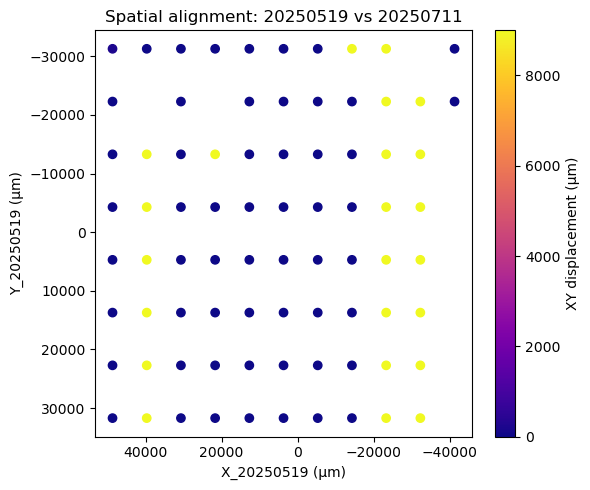


⚠️ Wells >500 µm apart:
     P   xy_dist_um  x_um_20250519  y_um_20250519  x_um_20250711  \
8    8  9000.400005        39678.6        31722.8        39678.9   
9    9  9000.200001        39678.7        22722.5        39678.8   
10  10  9000.000001        39678.8        13722.4        39678.9   
11  11  8999.800000        39678.8         4722.3        39678.8   
12  12  9000.100000        39678.8        -4277.6        39678.8   
13  13  8999.900000        39678.7       -13277.6        39678.7   
28  28  9000.000002        21678.6       -13277.5        21678.8   
61  61  9000.100001       -14321.2       -31277.5       -23321.3   
62  62  9000.000002       -23321.3       -31277.6       -23321.1   
63  63  8999.900000       -23321.1       -22277.4       -23321.1   
64  64  9000.200001       -23321.2       -13277.5       -23321.1   
65  65  8999.900000       -23321.2        -4277.5       -23321.2   
66  66  9000.200000       -23321.2         4722.5       -23321.2   
67  67  9000.100000    

In [21]:
from pathlib import Path
import nd2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------

def find_nd2(exp: str, base: Path) -> Path:
    """Locate the ND2 file for a given experiment folder."""
    nd2_path = next((base / "raw_image_data" / "YX1" / exp).glob("*.nd2"))
    print(f"File located for {exp}: {nd2_path}")
    return nd2_path

def get_stage_positions_fast(f):
    """Return one stage position per P (first T,Z,C) — ~500× faster."""
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W", 1))
    T = sizes.get("T", 1)
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)
    records = []

    for w in range(P):
        idx = ((0 * P) + w) * (Z * C)  # T=0, Z=0, C=0
        try:
            md = f.frame_metadata(idx)
        except Exception as e:
            print(f"⚠️ Skipping P={w}: {e}")
            continue

        ch = getattr(md, "channels", [None])[0]
        if ch is None:
            continue
        pos = getattr(ch, "position", None)
        if not pos or not hasattr(pos, "stagePositionUm"):
            continue

        stage = pos.stagePositionUm
        records.append({
            "P": w,
            "x_um": getattr(stage, "x", np.nan),
            "y_um": getattr(stage, "y", np.nan),
            "z_um": getattr(stage, "z", np.nan)
        })

    df = pd.DataFrame(records)
    return df.sort_values("P").reset_index(drop=True)


def get_stage_positions(f):
    """Return DataFrame of P→(x,y,z) positions (compatible with all nd2 APIs)."""
    records = []
    sizes = f.sizes
    P = sizes.get("P", sizes.get("W", 1))
    T = sizes.get("T", 1)
    Z = sizes.get("Z", 1)
    C = sizes.get("C", 1)

    total_frames = P * T * Z * C

    for i in range(total_frames):
        try:
            md = f.frame_metadata(i)
        except Exception as e:
            print(f"⚠️ Could not read frame {i}: {e}")
            continue

        # defensive extraction
        ch = getattr(md, "channels", [None])[0]
        if ch is None:
            continue

        loops = getattr(ch, "loops", None)
        pos = getattr(ch, "position", None)
        if pos is None or not hasattr(pos, "stagePositionUm"):
            continue

        stage = pos.stagePositionUm
        records.append({
            "P": getattr(loops, "XYPosLoop", None),
            "T": getattr(loops, "TimeLoop", None),
            "Z": getattr(loops, "ZStackLoop", None),
            "x_um": getattr(stage, "x", np.nan),
            "y_um": getattr(stage, "y", np.nan),
            "z_um": getattr(stage, "z", np.nan)
        })

    df = pd.DataFrame(records)
    df = df.dropna(subset=["P"]).drop_duplicates(subset="P").sort_values("P").reset_index(drop=True)
    return df



def check_duplicates(f):
    """Detect duplicate (P,T,Z) triplets."""
    seen, dups = set(), []
    for i in range(len(f)):
        md = f.frame_metadata(i)
        ch = md.channels[0]
        key = (ch.loops.XYPosLoop, ch.loops.TimeLoop, ch.loops.ZStackLoop)
        if key in seen:
            dups.append(key)
        else:
            seen.add(key)
    return dups


def inspect_frame(f, P, T=0, Z=0, C=0):
    """Print quick metadata + return image for a specific (P,T,Z)."""
    sizes = f.sizes
    Zmax, Cmax = sizes.get("Z", 1), sizes.get("C", 1)
    idx = ((T * sizes["P"]) + P) * (Zmax * Cmax) + (Z * Cmax + C)
    md = f.frame_metadata(idx)
    ch = md.channels[0]
    pos = ch.position.stagePositionUm
    print(f"P={P}, T={T}, Z={Z}")
    print(f"  Stage: x={pos.x:.1f}, y={pos.y:.1f}, z={pos.z:.1f}")
    print(f"  Relative time: {ch.time.relativeTimeMs:.1f} ms")
    img = f.asarray(idx)
    print(f"  Image shape={img.shape}, dtype={img.dtype}")
    return img

def report_missing_wells(df: pd.DataFrame, exp_name: str = "experiment", total: int = 96):
    """
    Report which well positions (P) are missing from an ND2 stage-position dataframe.

    Args:
        df: DataFrame containing a 'P' column of well indices (0-based).
        exp_name: Name of the experiment for reporting.
        total: Total number of expected wells (default=96 for a full 8x12 plate).
    """
    expected = set(range(total))
    found = set(df["P"].unique())
    missing = sorted(list(expected - found))

    print(f"\n📋 {exp_name}: {len(found)}/{total} wells present.")
    if missing:
        print(f"⚠️ Missing wells ({len(missing)}): {missing}")
    else:
        print("✅ All wells present.")
    return missing

# ---------- comparison ----------
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

def find_nearest_positions(df_ref: pd.DataFrame,
                           df_target: pd.DataFrame,
                           exp_target: str,
                           exp_ref: str,
                           max_dist_um: float = 1000.0) -> pd.DataFrame:
    """
    For each well in df_target, find the nearest (x,y) stage position in df_ref.

    Args:
        df_target: DataFrame with columns ["P", "x_um", "y_um"] for target experiment.
        df_ref: DataFrame with columns ["P", "x_um", "y_um"] for reference experiment.
        exp_target: name of target experiment (e.g. '20250519')
        exp_ref: name of reference experiment (e.g. '20250711')
        max_dist_um: threshold above which matches are flagged as "unmatched"

    Returns:
        DataFrame with columns:
          P_target, nearest_P_ref, xy_dist_um, x_um_target, y_um_target, x_um_ref, y_um_ref
    """
    ref_coords = df_ref[["x_um", "y_um"]].to_numpy()
    ref_P = df_ref["P"].to_numpy()
    tree = cKDTree(ref_coords)

    target_coords = df_target[["x_um", "y_um"]].to_numpy()
    dists, idxs = tree.query(target_coords, k=1)

    matches = pd.DataFrame({
        "P_target": df_target["P"].to_numpy(),
        "nearest_P_ref": ref_P[idxs],
        "xy_dist_um": dists,
        "x_um_target": df_target["x_um"].to_numpy(),
        "y_um_target": df_target["y_um"].to_numpy(),
        "x_um_ref": df_ref.loc[ref_P[idxs], "x_um"].to_numpy(),
        "y_um_ref": df_ref.loc[ref_P[idxs], "y_um"].to_numpy(),
    })

    matches["is_matched"] = matches["xy_dist_um"] <= max_dist_um

    print(f"\n🔍 Nearest-position mapping ({exp_target} → {exp_ref}):")
    print(f"  Mean XY distance: {matches['xy_dist_um'].mean():.1f} µm")
    print(f"  Median XY distance: {matches['xy_dist_um'].median():.1f} µm")
    print(f"  Wells > {max_dist_um} µm apart: {(~matches['is_matched']).sum()} / {len(matches)}")

    return matches

from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

def match_positions_with_reference(df_target: pd.DataFrame,
                                   df_ref: pd.DataFrame,
                                   exp_target: str,
                                   exp_ref: str,
                                   max_dist_um: float = 1000.0) -> pd.DataFrame:
    """
    Match each well in df_target to its counterpart in df_ref.

    Strategy:
      1️⃣ If same P index exists in df_ref → use that directly.
      2️⃣ Otherwise → find nearest (x,y) in df_ref using cKDTree.
      3️⃣ Report nearest match and distance in all cases.

    Returns:
        DataFrame with:
          P_target, match_type ('same_P' or 'nearest'),
          nearest_P_ref, xy_dist_um,
          x_um_target, y_um_target, x_um_ref, y_um_ref
    """
    # Build reference coordinate lookup
    ref_coords = df_ref[["x_um", "y_um"]].to_numpy()
    ref_P = df_ref["P"].to_numpy()
    tree = cKDTree(ref_coords)

    matches = []
    for _, row in df_target.iterrows():
        P_t = row["P"]
        x_t, y_t = row["x_um"], row["y_um"]

        # Case 1: Same P exists in reference
        ref_row = df_ref[df_ref["P"] == P_t]
        if len(ref_row):
            x_r, y_r = ref_row.iloc[0][["x_um", "y_um"]]
            dist = np.hypot(x_t - x_r, y_t - y_r)
            match_type = "same_P"
            nearest_P = P_t
        else:
            # Case 2: find nearest by position
            dist, idx = tree.query([x_t, y_t])
            nearest_P = ref_P[idx]
            x_r, y_r = ref_coords[idx]
            match_type = "nearest"

        matches.append({
            "P_target": P_t,
            "nearest_P_ref": nearest_P,
            "match_type": match_type,
            "xy_dist_um": dist,
            "x_um_target": x_t,
            "y_um_target": y_t,
            "x_um_ref": x_r,
            "y_um_ref": y_r,
            "is_matched": dist <= max_dist_um
        })

    matches_df = pd.DataFrame(matches)

    # --- Summary ---
    n_same = (matches_df["match_type"] == "same_P").sum()
    n_near = (matches_df["match_type"] == "nearest").sum()
    n_far = (~matches_df["is_matched"]).sum()

    print(f"\n🔍 Matching {exp_target} → {exp_ref}:")
    print(f"  Same-P matches: {n_same}")
    print(f"  Nearest-neighbor matches: {n_near}")
    print(f"  Mean XY distance: {matches_df['xy_dist_um'].mean():.1f} µm")
    print(f"  Median XY distance: {matches_df['xy_dist_um'].median():.1f} µm")
    print(f"  Wells > {max_dist_um} µm apart: {n_far} / {len(matches_df)}")

    return matches_df



def compare_nd2_positions(exp1: str, exp2: str, base: Path):
    f1_path = find_nd2(exp1, base)
    f2_path = find_nd2(exp2, base)

    with nd2.ND2File(str(f1_path)) as f1, nd2.ND2File(str(f2_path)) as f2:
        df1 = get_stage_positions_fast(f1)
        df2 = get_stage_positions_fast(f2)

        # Report missing wells for each
        missing_1 = report_missing_wells(df1, exp1)
        missing_2 = report_missing_wells(df2, exp2)



        nearest_df = match_positions_with_reference(
            df_target=df1,
            df_ref=df2,
            exp_target="20250519",
            exp_ref="20250711",
            max_dist_um=500
        )


        print(f"\n{exp1}: {len(df1)} wells | {exp2}: {len(df2)} wells")

        merged = pd.merge(df1, df2, on="P", suffixes=(f"_{exp1}", f"_{exp2}"))

        merged["xy_dist_um"] = np.sqrt(
            (merged[f"x_um_{exp1}"] - merged[f"x_um_{exp2}"]) ** 2 +
            (merged[f"y_um_{exp1}"] - merged[f"y_um_{exp2}"]) ** 2
        )
        merged["z_diff_um"] = merged[f"z_um_{exp1}"] - merged[f"z_um_{exp2}"]

        print("\nDisplacement summary (µm):")
        print(merged[["xy_dist_um", "z_diff_um"]].describe())

        plt.figure(figsize=(6,5))
        plt.scatter(merged[f"x_um_{exp1}"], merged[f"y_um_{exp1}"],
                    c=merged["xy_dist_um"], cmap="plasma")
        plt.colorbar(label="XY displacement (µm)")
        plt.xlabel(f"X_{exp1} (µm)")
        plt.ylabel(f"Y_{exp1} (µm)")
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
        plt.title(f"Spatial alignment: {exp1} vs {exp2}")
        plt.tight_layout()
        plt.show()

        # Outliers
        outliers = merged[merged["xy_dist_um"] > 500]
        if not outliers.empty:
            print("\n⚠️ Wells >500 µm apart:")
            print(outliers[["P", "xy_dist_um",
                            f"x_um_{exp1}", f"y_um_{exp1}",
                            f"x_um_{exp2}", f"y_um_{exp2}"]])

        return nearest_df


# ---------- run example ----------

if __name__ == "__main__":
    base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
    nearest_df = compare_nd2_positions("20250519", "20250711", base)


In [4]:
from pathlib import Path

exp = "20250711"
base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
search_dir = base / "raw_image_data" / "YX1" / exp
print(search_dir)
print(list(search_dir.glob("*")))


/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250711
[PosixPath('/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250711/tmem67_start31hpf_20250711.nd2')]


File located for 20250711: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250711/tmem67_start31hpf_20250711.nd2
File located for 20250519: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/raw_image_data/YX1/20250519/b9d2_starthpf_10_20250519.nd2

📋 20250711: 93/96 wells present.
⚠️ Missing wells (3): [93, 94, 95]

📋 20250519: 79/96 wells present.
⚠️ Missing wells (17): [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]

🔍 Matching 20250519 → 20250711:
  Same-P matches: 79
  Nearest-neighbor matches: 14
  Mean XY distance: 4107.2 µm
  Median XY distance: 0.2 µm
  Wells > 500 µm apart: 37 / 93

20250711: 93 wells | 20250519: 79 wells

Displacement summary (µm):
        xy_dist_um     z_diff_um
count    79.000000  7.900000e+01
mean   2623.317294  1.272200e+02
std    4112.852974  8.580996e-14
min       0.000000  1.272200e+02
25%       0.100000  1.272200e+02
50%       0.223607  1.272200e+02
75%    8999.900000  1.2722

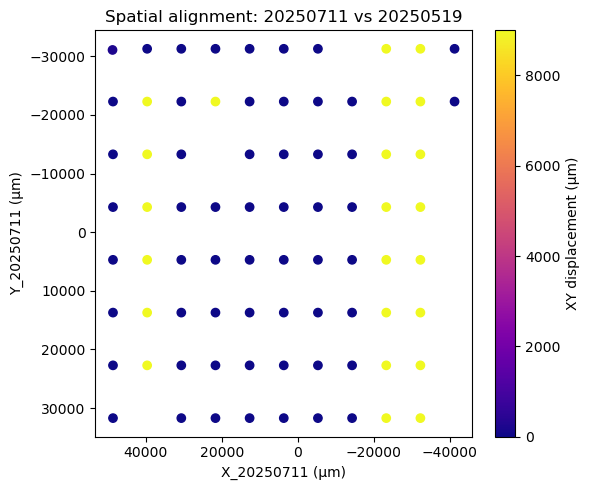


⚠️ Wells >500 µm apart:
     P   xy_dist_um  x_um_20250711  y_um_20250711  x_um_20250519  \
8    8  9000.400005        39678.9        22722.4        39678.6   
9    9  9000.200001        39678.8        13722.3        39678.7   
10  10  9000.000001        39678.9         4722.4        39678.8   
11  11  8999.800000        39678.8        -4277.5        39678.8   
12  12  9000.100000        39678.8       -13277.7        39678.8   
13  13  8999.900000        39678.7       -22277.5        39678.7   
28  28  9000.000002        21678.8       -22277.5        21678.6   
61  61  9000.100001       -23321.3       -31277.6       -14321.2   
62  62  9000.000002       -23321.1       -22277.6       -23321.3   
63  63  8999.900000       -23321.1       -13277.5       -23321.1   
64  64  9000.200001       -23321.1        -4277.3       -23321.2   
65  65  8999.900000       -23321.2         4722.4       -23321.2   
66  66  9000.200000       -23321.2        13722.7       -23321.2   
67  67  9000.100000    

In [20]:
if __name__ == "__main__":
    base = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground")
    compare_nd2_positions("20250711", "20250519", base)

In [17]:
nearest_df

,P_target,nearest_P_ref,match_type,xy_dist_um,x_um_target,y_um_target,x_um_ref,y_um_ref,is_matched
0,0.0,0.0,same_P,231.821591,48801.5,-31080.9,48678.5,-31277.4,True
1,1.0,1.0,same_P,0.223607,48678.9,-22277.4,48678.7,-22277.5,True
2,2.0,2.0,same_P,0.223607,48678.9,-13277.5,48678.7,-13277.6,True
3,3.0,3.0,same_P,0.223607,48678.9,-4277.2,48678.7,-4277.3,True
4,4.0,4.0,same_P,0.223607,48678.8,4722.7,48678.7,4722.5,True
...,...,...,...,...,...,...,...,...,...
88,88.0,73.0,nearest,17999.900000,-50321.1,4722.4,-32321.2,4722.3,False
89,89.0,74.0,nearest,17999.900000,-50321.1,-4277.5,-32321.2,-4277.6,False
90,90.0,78.0,nearest,12727.709930,-50321.1,-13277.6,-41321.2,-22277.4,False
91,91.0,78.0,nearest,8999.900001,-50321.1,-22277.5,-41321.2,-22277.4,False
